In [1]:
import sys
sys.path.append('../radiospectra2')
from radiospectra.sources import CallistoSpectrogram 
from Orfees_read import *
from scipy import signal
from datetime import timedelta
from matplotlib.ticker import ScalarFormatter, MaxNLocator

the Orfees methods are imported....


In [2]:
import pandas as pd


def get_frequency_range(source, target):
    """
    Extracts the frequency range from the source that matches the target's frequency range.
    
    Parameters:
        source (DataFrame): The source data frame containing frequency data and observations.
        target (DataFrame): The target data frame with the desired frequency range.
    
    Returns:
        tuple: A tuple containing the filtered data, minimum frequency, maximum frequency, and frequency range.
    """
    min_freq = target.freq_axis.min()
    max_freq = target.freq_axis.max()
    mask = (source.freq_axis > min_freq) & (source.freq_axis < max_freq)
    filtered_data = source.data[mask, :]
    
    return filtered_data, min_freq, max_freq, source.freq_axis[mask]



def get_dates_from_spectrum(spectrum):
    """
    Generates a list of datetime objects representing the observation times within a spectrum.
    
    Parameters:
        spectrum (DataFrame): The spectrum data frame containing observation start and end times, and the time delta.
    
    Returns:
        list: A list of datetime objects for each observation time.
    """
    start_time = datetime.datetime.strptime(f"{spectrum.header['DATE-OBS']} {spectrum.header['TIME-OBS']}", "%Y/%m/%d %H:%M:%S.%f")
    end_time = datetime.datetime.strptime(f"{spectrum.header['DATE-END']} {spectrum.header['TIME-END']}", "%Y/%m/%d %H:%M:%S")
    delta_time = spectrum.header['CDELT1']
    dates = [start_time + timedelta(seconds=delta_time * i) for i in range(int((end_time - start_time).total_seconds() / delta_time))]
    
    return dates



# Converts intensity data to decibels using a specified factor
def intensity_to_db(df, factor=0.0386):
    return 10 ** (df * factor)


def plot_data(df, spec):
    
    orfees_dates = sorted(df.convert_ms_to_date())
    spec_dates = get_dates_from_spectrum(spec)
    filtered_data, min_freq, max_freq, frequency_range = get_frequency_range(df, spec)
    filtered_data = signal.medfilt2d(filtered_data, kernel_size=3)


    spec_df = pd.DataFrame(spec.data)

    ecallisto_data_db = intensity_to_db(pd.DataFrame(spec_df))
    scaled_ecallisto_data_db = ecallisto_data_db 



    orfees_min = min(frequency_range )
    orfees_max = max(frequency_range )

    ymin, ymax = spec.freq_axis.min(), spec.freq_axis.max()

    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for row in axs:
        for ax in row:
            ax.xaxis.set_major_locator(MaxNLocator(prune='lower', nbins=8))

    for ax in axs[0]:
        ax.set_xticklabels(orfees_dates[::int(len(orfees_dates)//6)], rotation=50, horizontalalignment="right")

    for ax in axs[1]:
        tick_labels = [date.strftime('%H:%M:%S') for date in spec_dates[::int(len(spec_dates)//7)]]
        ax.set_xticklabels(tick_labels, rotation=50, horizontalalignment="right")

    axs[0, 0].imshow(filtered_data, vmin=np.nanmin(filtered_data), vmax=1000, aspect="auto")
    axs[0, 0].set_title("ORFEES")
    axs[0, 0].set_xlabel('Time [UT]')
    axs[0, 0].set_ylabel('Frequency [MHz]')
    axs[0, 0].set_ylim(orfees_max, orfees_min)

    axs[1, 0].imshow(spec.data[::-1], aspect="auto", extent=[-1, spec.shape[1], ymax, ymin])
    axs[1, 0].set_title("eCallisto_BIR")
    axs[1, 0].set_xlabel('Time [UT]')
    axs[1, 0].set_ylabel('Frequency [MHz]')
    
    axs[0, 1].plot(np.nansum(filtered_data, axis=0))
    axs[0, 1].set_ylabel('Intensity [sfu]')
    axs[0, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    axs[1, 1].plot(np.nansum(scaled_ecallisto_data_db, axis=0))
    axs[1, 1].set_ylabel('Intensity')
    axs[1, 1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2540157/2883573151.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(orfees_dates[::int(len(orfees_dates)//6)], rotation=50, horizontalalignment="right")
/tmp/ipykernel_2540157/2883573151.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=50, horizontalalignment="right")


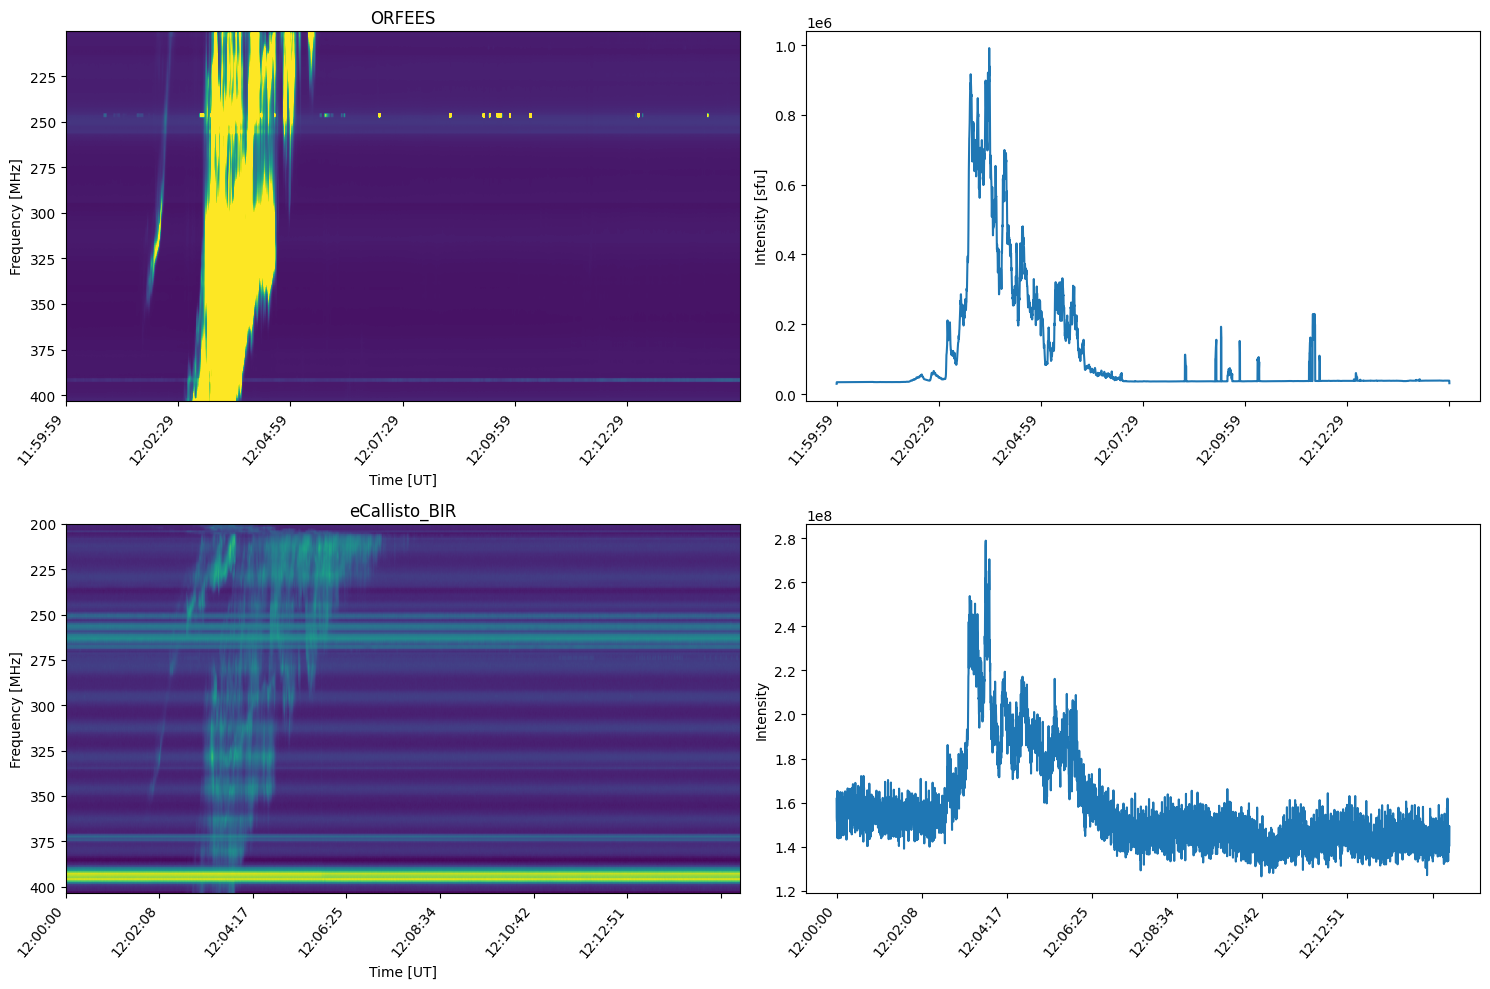

In [4]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
spec = CallistoSpectrogram.read("eca_files/BIR_20151104_120000_03 (1).fit.gz")

plot_data(orfees, spec)

/tmp/ipykernel_2540157/2883573151.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(orfees_dates[::int(len(orfees_dates)//6)], rotation=50, horizontalalignment="right")
/tmp/ipykernel_2540157/2883573151.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=50, horizontalalignment="right")


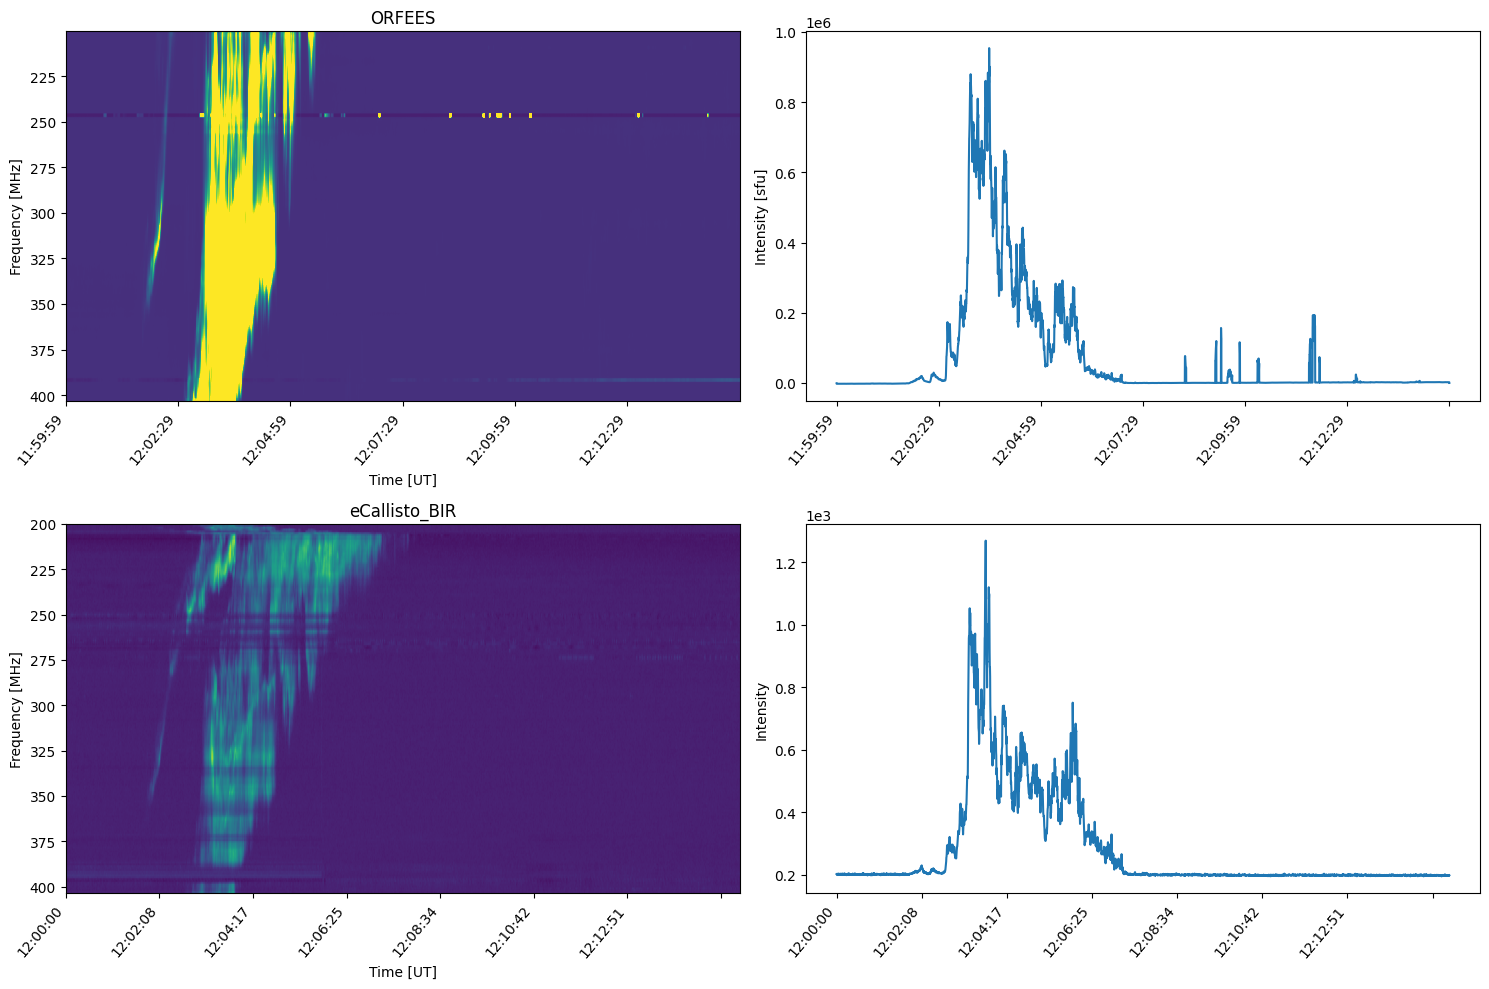

In [5]:
orfees = OrfeesSpectrogram("./orfees_files/int_orf20151104_120000_0.1_test.fts")
orfees_sb = orfees.subtract_bg()
spec = CallistoSpectrogram.read("eca_files/BIR_20151104_120000_03 (1).fit.gz")
spec_sb=spec.subtract_bg()

plot_data(orfees_sb, spec_sb)